## Model description:
This model investigates potential impact of a well on ACME Co. farmland on nearby Wildcat Farm. 

### Dimensions:
* 3300 m by 3300 m
* dx = dy = 100 m
* dz = 300 m

### Subsurface properties:
* The subsurface in this model is heterogeneous
* Horzontal hydraulic conductivity is separated into different values on the top and bottom halves of the model based on observation well log information:
    * Kh (Top): 1.25 m/day
    * Kh (Bottom): 10.70 m/day
* Vertical hydrualic conductivity was assumed to be constant throughout the model domain:
    * Kv (vertical): ??? m/day
* Porosity:
* Specific yield:
* Storage coefficient: 

### Boundary conditions:
* #Right and left boundaries should be chd, define
* #Top and bottom should be nfb, define

## 1. Set up environment

In [1]:
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
#Chloe, delete some if unused
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

%matplotlib inline 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# If you want to calculate the harmonic mean in python you need to conda install scipy 
# and uncomment this line
from scipy.stats import hmean

## 2. Create model object

In [2]:
modelname = "Wildcat_Farm_2026"
moddir = '../../../modflow/mf2005'
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

## 3. Set up discretization

### 3.1 Define model grid

In [7]:
nrow = 33 #number of rows
ncol = 33 #number of columns
nlay = 1  #number of layers

dx= 100 #width of grid cells in x direction, in meters
dy= 100 #width of grid cells in y direction, in meters 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 300.    #top elevation, land surface
zbot = 0.     #bottom elevation, base of aquifer

dz = (ztop - zbot) / nlay #cell height in z direction

### 3.2 Temporal discretization

In [8]:
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

### 3.3 Create DIS object

In [15]:
#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

### 3.4 Plot model grid

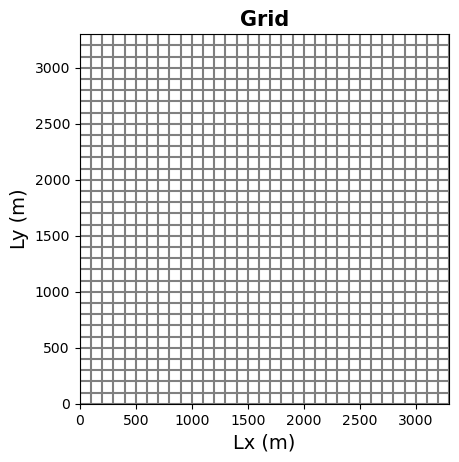

In [10]:
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

## 4. Define boundary conditions and initial conditions (BAS)

### 4.1 Define boundary conditions using IBOUND

#### 4.1a: Set up constant head cells

In [11]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)  

#set constant head boundaries
ibound[:,:,0] = -1          
ibound[:,:,-1] = -1          

In [12]:
H_west = 295.0
H_east = 249.0
H_init = np.zeros((nlay, nrow, ncol), dtype=np.float32)
for j in range(ncol):
    frac = j / (ncol - 1)
    H_init[:, :, j] = H_west + frac * (H_east - H_west)

In [ ]:
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#### 4.1b: Plot model grid with boundaries to confirm

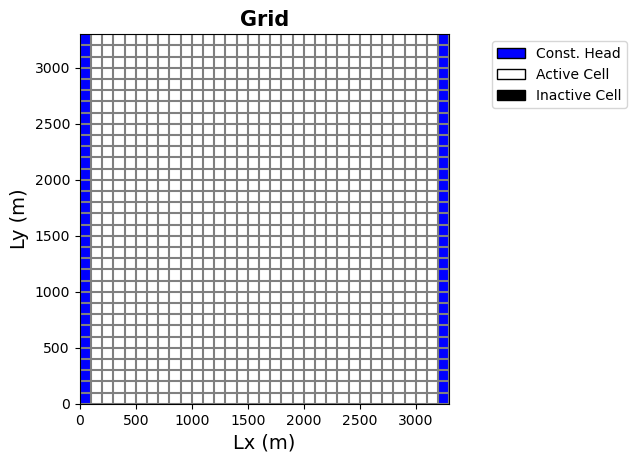

In [14]:
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()

plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

In [ ]:
K_horiz_top = 1.25    
K_horiz_bottom = 10.70
K_vert = 1    #assign vertical hydraulic conductivity (along z axis)

n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined 